# End-to-End Speech Recognition in Tensorflow

##### The dataset that will be used for this tutorial is from [Speech Recognition Challenge in Kaggle](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data)
##### It has 65,000 one-second long utterances of 30 short words, by thousands of different people. We’ll build a speech recognition system that understands simple spoken commands.
##### The 10 labels we will need to predict in Test-set are 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', and 'go'. Everything else should be considered either unknown or NA.

In [8]:
import os
# LibROSA is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.
import librosa
from scipy.io import wavfile
import warnings

import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
import datetime
import os
import math
import random
import pathlib
import json
import pickle
import re
from tqdm import tqdm

from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard

Python version: 3.7.6
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
# checking current directory
os.path.abspath('./data')

'C:\\Users\\bokhy\\Desktop\\Python\\Python-Projects\\Tensorflow\\data'

# 1. Load Data

#### Librosa tutorial and codes 
#### https://librosa.github.io/librosa/tutorial.html

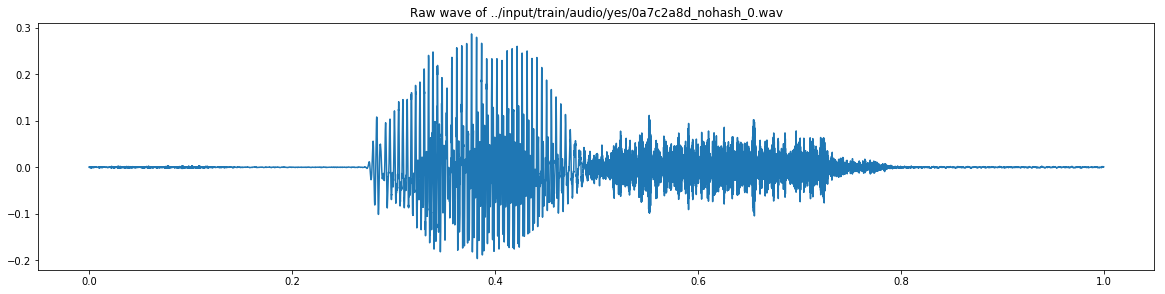

In [10]:
train_audio_path = 'E:/Python/data/tensorflow-speech-recognition-challenge/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)
ax.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

# 2. Audio EDA

In [11]:
# Check the Sampling Rate
ipd.Audio(samples, rate=sample_rate)

In [12]:
# check sampling rate
print(sample_rate)

16000


In [14]:
# Resample
# We see that the sampling rate of the signal is 16000 hz. Let's resample it to 8000 hz (since most of the speech related frequencies are present in 8000z)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

[ 1.5111059e-05 -9.0932073e-05  1.6909138e-04 ...  1.2670006e-03
  5.7899451e-04  2.8395216e-04]


In [16]:
os.listdir(train_audio_path)

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero',
 '_background_noise_']

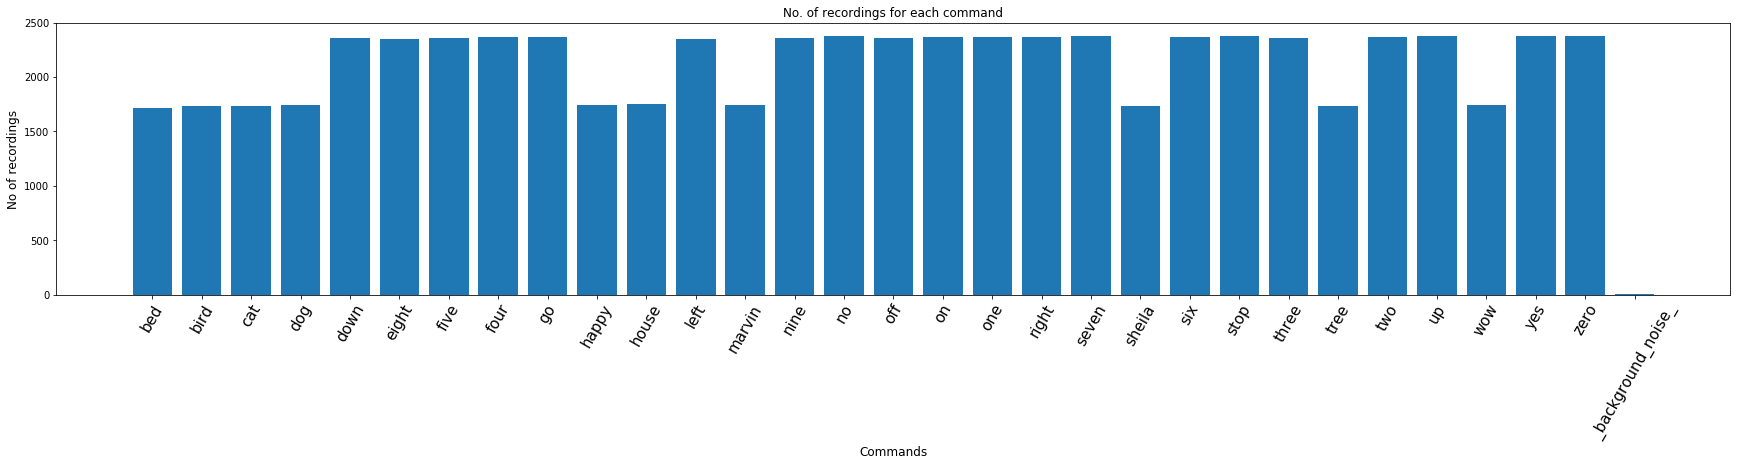

In [17]:
# number of recordings for each voice command
labels=os.listdir(train_audio_path)

recording=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    recording.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, recording)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [18]:
# List out lables
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

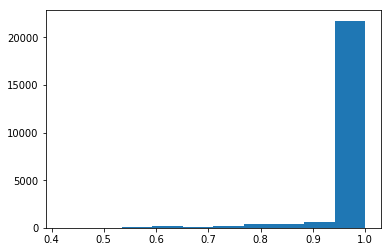

In [19]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

# 3. Data Pre-processing

### Duration of a few recordings is less than 1 second and the sampling rate is too high.

##### (1) Resampling
##### (2) Remove outliers (audio shorter than 1 second)

In [20]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


##### (3) Convert the output labels to integer-encoded:

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


##### (4) Convert integer-encoded to a one-hot vector since it is a multi-classification problem

In [29]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

##### (5) Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [30]:
all_wave = np.array(all_wave).reshape(-1,8000,1) ; all_wave

array([[[-2.88872398e-03],
        [-4.09192173e-03],
        [-3.25268088e-03],
        ...,
        [-7.19285978e-04],
        [-1.12521090e-03],
        [-1.30131142e-03]],

       [[ 4.03327926e-04],
        [ 6.26417692e-04],
        [ 3.67147470e-04],
        ...,
        [ 8.11780745e-04],
        [ 4.86697943e-04],
        [ 7.11379049e-04]],

       [[-1.58481183e-04],
        [-1.79531227e-04],
        [-1.15519455e-04],
        ...,
        [ 4.31013264e-04],
        [ 3.31727992e-04],
        [ 3.07029666e-04]],

       ...,

       [[-1.52462671e-04],
        [-2.13622799e-04],
        [-1.75312554e-04],
        ...,
        [ 4.78350848e-04],
        [ 3.12889199e-04],
        [ 2.94630474e-04]],

       [[-5.92960969e-05],
        [-1.66434096e-04],
        [-1.80037678e-04],
        ...,
        [ 1.01546226e-04],
        [-4.89999038e-05],
        [-1.18220858e-04]],

       [[ 1.62130367e-04],
        [ 4.54971945e-04],
        [ 3.75219883e-04],
        ...,
        

# 4. Train/Test Split

In [31]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),
                                            stratify = y,
                                            test_size = 0.2,
                                            random_state = 623,
                                            shuffle = True)

# 5. Create a Model

# We build the model in convulutional-1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension.

In [32]:
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

# 6. Train a model

In [33]:
# Loss function
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=10, 
                   min_delta=0.0001) 

checkpoint = ModelCheckpoint('best_model.hdf5', 
                     monitor='val_acc', 
                     verbose=True, 
                     save_best_only=True, 
                     mode='max')

In [35]:
model_history=model.fit(x_tr, y_tr,
                  epochs=100, 
                  callbacks=[early_stopping,checkpoint], 
                  batch_size=32, 
                  validation_data=(x_val,y_val))

Train on 17049 samples, validate on 4263 samples
Epoch 1/100
17049/17049 [==============================] - 75s 4ms/step - loss: 2.0043 - accuracy: 0.2424 - val_loss: 1.6191 - val_accuracy: 0.4356
Epoch 2/100
17049/17049 [==============================] - 67s 4ms/step - loss: 1.3507 - accuracy: 0.5117 - val_loss: 1.0047 - val_accuracy: 0.6542
Epoch 3/100
17049/17049 [==============================] - 71s 4ms/step - loss: 1.0682 - accuracy: 0.6206 - val_loss: 0.9290 - val_accuracy: 0.6866
Epoch 4/100
17049/17049 [==============================] - 73s 4ms/step - loss: 0.9245 - accuracy: 0.6765 - val_loss: 0.8162 - val_accuracy: 0.7225
Epoch 5/100
17049/17049 [==============================] - 70s 4ms/step - loss: 0.8274 - accuracy: 0.7097 - val_loss: 0.6851 - val_accuracy: 0.7652
Epoch 6/100
17049/17049 [==============================] - 69s 4ms/step - loss: 0.7629 - accuracy: 0.7352 - val_loss: 0.7226 - val_accuracy: 0.7478
Epoch 7/100
17049/17049 [==============================] - 72s 

In [36]:
def render_training_history(model_history):
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

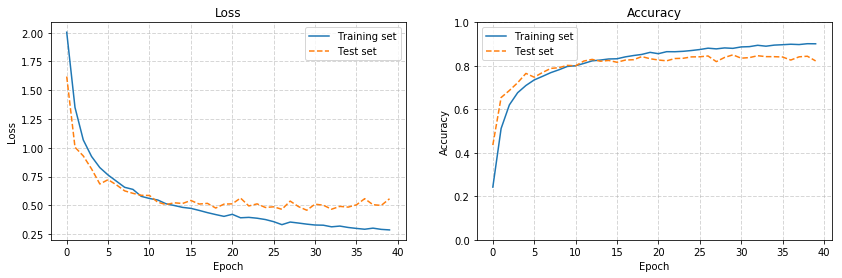

In [37]:
render_training_history(model_history)

# 7. Loading the best model

In [39]:
from keras.models import load_model
# Load the model for later use
# model=load_model('best_model.hdf5')

In [40]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

# 8. Evaluate and Predict

In [43]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: off


In [44]:
print("Text:",predict(samples))

Text: off


> The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

In [ ]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

# 9. Use my own voice record and convert it to text:

In [ ]:
os.listdir('../input/voice-commands/prateek_voice_v2')

In [ ]:
filepath='../input/voice-commands/prateek_voice_v2'

In [ ]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

In [ ]:
#converting voice commands to text
predict(samples)

#### Reference
#### https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch
#### https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview 

##### Helpful Article 
> https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/